**Description**: Analyzes BERT *and* GPT-2 accuracies for a given number of test
observations (200 or 500). Currently just 2 chains. Need to increase that, but it's too
slow :-(

**Estimated runtime**: ~1 hour (Multi-core isn't working on my machine. Set
`cores=4` in the `model.fit` call if it works for you.)

In [1]:
from typing import Literal

import matplotlib.pyplot as plt
import seaborn as sns

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Configuration

Which number of test observations do you want to analyze?

In [3]:
num_test: Literal[200, 500] = 200

# Load data

In [4]:
accuracies_home_dir = "accuracies_from_paper"
accuracy_df = utils.load_all_accuracies(accuracies_home_dir, num_test)  # for plot
num_correct_df = utils.load_all_num_correct(accuracies_home_dir, num_test)  # for model

In [5]:
equation = "p(num_correct, num_test) ~ method + lm_type + (1|dataset/pair)"
id_vars = ["num_test", "pair", "lm_type", "dataset"]

# Plot

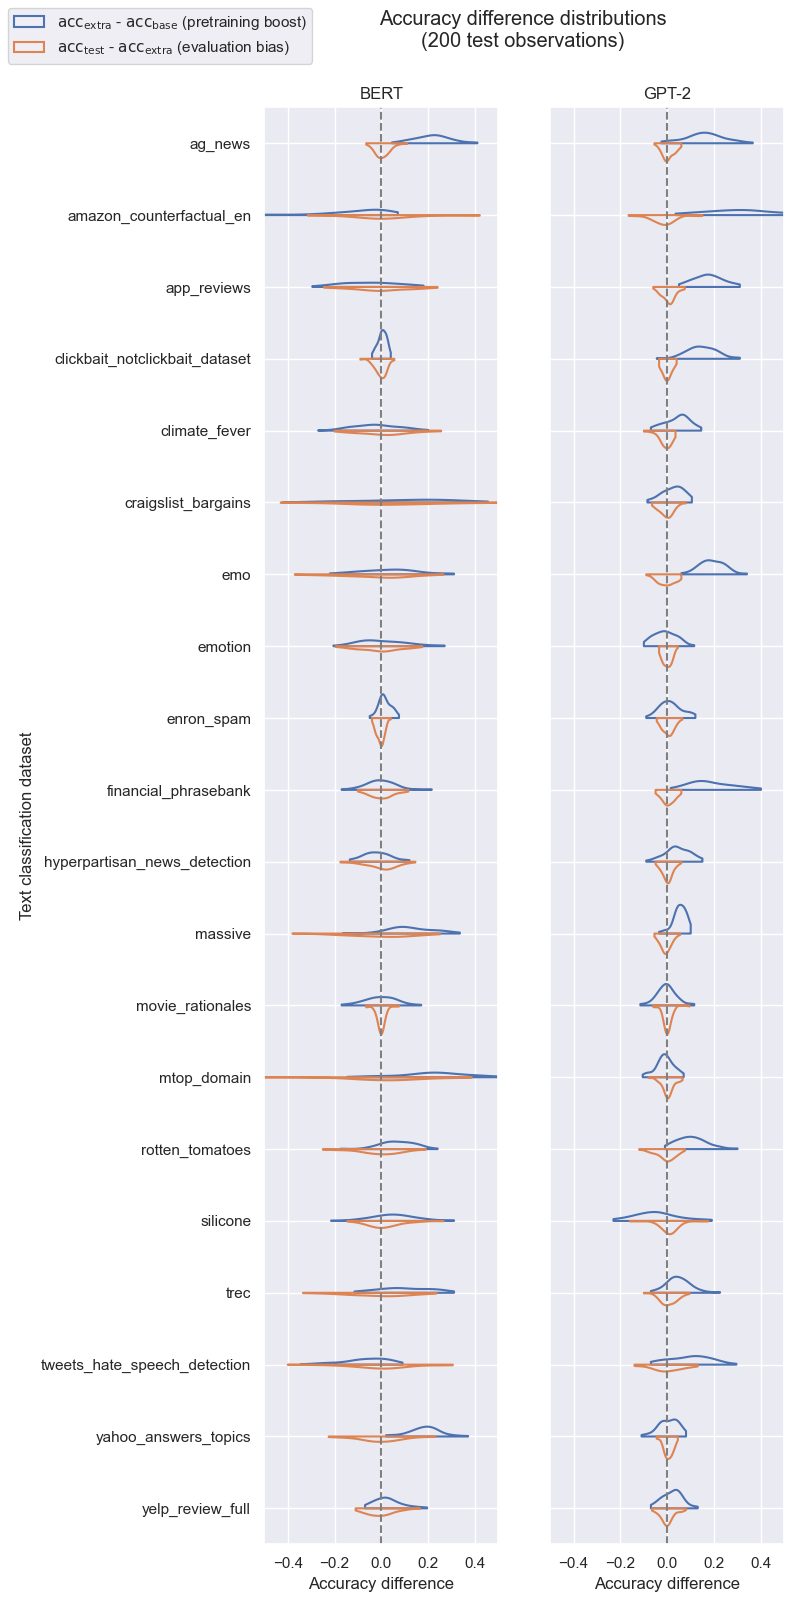

In [6]:
num_lm_types = accuracy_df["lm_type"].unique().len()
fig, axes = plt.subplots(
    nrows=1,
    ncols=accuracy_df["lm_type"].unique().len(),
    figsize=(4 * num_lm_types, 16),
)
xlim = (-0.5, 0.5)
axes: list[plt.Axes]
for i, (lm_type, accuracy_df_lm) in enumerate(
    accuracy_df.group_by("lm_type", maintain_order=True)
):
    ax = axes[i]
    ax.set_xlim(xlim)
    _ = utils.violin_plot(accuracy_df_lm, title=utils.lm_type_to_name[lm_type], ax=ax)
    if i > 0:
        ax.set_yticklabels([])
        ax.set_ylabel(" ")
fig.suptitle(
    f"Accuracy difference distributions\n({num_test} test observations)", y=1, x=0.65
)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left")
fig.tight_layout()

# Control

/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Intercept, method, lm_type, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1191 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[extra],0.314,0.005,0.304,0.323,0.0,0.0,1071.0,720.0,NaN


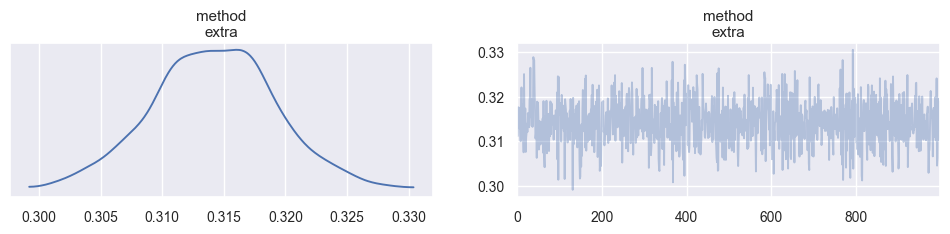

In [7]:
model_control, summary_control, az_summary_control = utils.stat_model(
    num_correct_df,
    treatment="extra",
    control="base",
    equation=equation,
    id_vars=id_vars,
    chains=1,
)

In [8]:
print(model_control)

       Formula: p(num_correct, num_test) ~ method + lm_type + (1|dataset/pair)
        Family: binomial
          Link: p = logit
  Observations: 4000
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            method ~ Normal(mu: 0.0, sigma: 1.0)
            lm_type ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


# Treatment

/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [Intercept, method, lm_type, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1187 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[test],0.012,0.005,0.002,0.022,0.0,0.0,2742.0,541.0,NaN


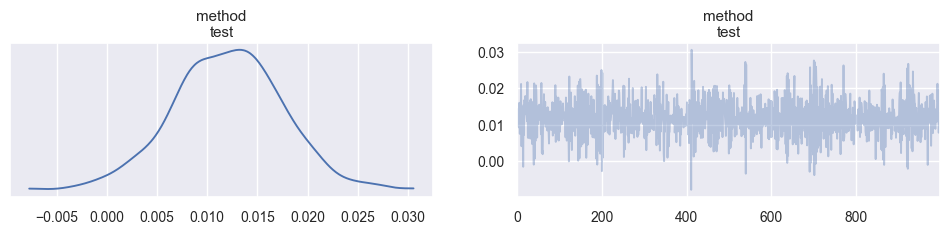

In [9]:
model_bias, summary_bias, az_summary_bias = utils.stat_model(
    num_correct_df,
    treatment="test",
    control="extra",
    equation=equation,
    id_vars=id_vars,
    chains=1,
)

In [10]:
print(model_bias)

       Formula: p(num_correct, num_test) ~ method + lm_type + (1|dataset/pair)
        Family: binomial
          Link: p = logit
  Observations: 4000
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            method ~ Normal(mu: 0.0, sigma: 1.0)
            lm_type ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()
